In [163]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [164]:
import numpy as np
import pandas as pd
import datetime as dt
#Use this to convert to Date Time format and Calculate time deltas
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [165]:
## Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect #added inspect

In [166]:
## Create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [167]:
## Reflect an existing database into a new model
Base = automap_base()
## Reflect the tables
Base.prepare(engine, reflect=True)

In [168]:
## View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [169]:
## Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [170]:
## Create the session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [171]:
## Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
tables = inspector.get_table_names()
tables

['measurement', 'station']

In [172]:
## Use Inspector to print the column names and types
for table in tables:
    print(f"Table: {table.capitalize()}")
    columns = inspector.get_columns(table)
    for c in columns:
        print(c['name'], c["type"])
    print(".............\n")

Table: Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
.............

Table: Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
.............



In [173]:
## Find the most recent date in the data set.
## The '\' at the end connects the line below it
results_meas = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).all()
#results_meas

results_meas[0]

('2017-08-23')

### Design a query to retrieve the last 12 months of precipitation data and plot the results, starting from the most recent data point in the database.

In [174]:
## Calculate the date one year from the last date in data set.
recent_date = results_meas[0]
#print(recent_date[0])

recent_date_datetime = datetime.strptime(recent_date[0], "%Y-%m-%d")
#type(recent_date_datetime)

## Use time delta to subtract 365 days from the datetime type varaible (recent_date_datetime)
minus_one_year = recent_date_datetime - timedelta(days = 365)

## Convert minus_one_year to a string
minus_one_year_str = datetime.strftime(minus_one_year,"%Y-%m-%d")
#minus_one_year

In [175]:
## Perform a query to retrieve the data and precipitation scores
data_meas = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= minus_one_year_str).all()
#data

In [176]:
data_meas[:5]

[(0.0, '2016-08-23'),
 (0.08, '2016-08-24'),
 (0.08, '2016-08-25'),
 (0.0, '2016-08-26'),
 (0.0, '2016-08-27')]

In [177]:
## Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(data_meas, columns = ["Precipitation", "Date"])
df_prcp_date_index = df_prcp.set_index("Date")

In [178]:
## Sort the dataframe by date
df_prcp_date_index = df_prcp_date_index.sort_index()
df_prcp_date_index.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [179]:
## Double check the data to make sure the plot will plot correctly
df_prcp_date_index['Precipitation'].sort_values(ascending=False)

Date
2016-09-14    6.70
2017-04-29    6.25
2017-02-11    5.04
2017-07-22    4.00
2016-10-04    3.46
              ... 
2017-08-13     NaN
2017-08-18     NaN
2017-08-19     NaN
2017-08-20     NaN
2017-08-21     NaN
Name: Precipitation, Length: 2230, dtype: float64

<AxesSubplot:xlabel='Date'>

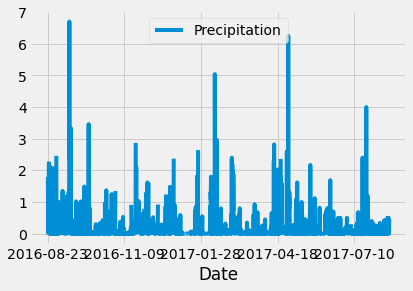

In [180]:
## Use Pandas Plotting with Matplotlib to plot the data
df_prcp_date_index.plot()

In [181]:
## Use Pandas to calculate the summary statistics for the precipitation data
## This is the long way to calculate the summary statistics
mean_prcp = df_prcp_date_index.mean()

median_prcp = df_prcp_date_index.median()

var_prcp = df_prcp_date_index.var()

std_prcp = df_prcp_date_index.std()

sem_prcp = df_prcp_date_index.sem()

sum_stats = pd.DataFrame({"Mean": mean_prcp, 
                          "Median": median_prcp,
                          "Variance": var_prcp,
                          "Std": std_prcp,
                          "SEM": sem_prcp
                         })

sum_stats

,Mean,Median,Variance,Std,SEM
Precipitation,0.177279,0.02,0.212696,0.46119,0.010259


In [182]:
## This is the easy way to calculate the summary statistics
df_prcp_date_index.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [183]:
## Design a query to calculate the total number stations in the dataset
results_sta_tot = session.query(Station.id).count()
results_sta_tot

9

In [184]:
## Design a query to find the most active stations (i.e. what stations have the most rows?)
## List the stations and the counts in descending order.

## Sample code:
## session.query(func.count(User.id)).\
##         group_by(User.name)

sta_count = func.count(Measurement.station)

results_sta_count = session.query(Measurement.station, sta_count).\
    group_by(Measurement.station).\
    order_by(sta_count.desc()).all()

results_sta_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [185]:
## Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = results_sta_count[0]
most_active

('USC00519281', 2772)

In [186]:
## Lowest, highest, and avg temps
calc = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs).\
             filter(Measurement.station == most_active[0])).all()
calc

[(53.0, 87.0, 71.66378066378067)]

In [187]:
## Using the most active station id
## Query the last 12 months of temperature observation data for this station and plot the results as a histogram

data_most_active = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_active[0]).all()
data_most_active

[('2017-08-18'),
 ('2017-08-17'),
 ('2017-08-16'),
 ('2017-08-15'),
 ('2017-08-14'),
 ('2017-08-13'),
 ('2017-08-06'),
 ('2017-08-05'),
 ('2017-08-04'),
 ('2017-07-31'),
 ('2017-07-30'),
 ('2017-07-29'),
 ('2017-07-28'),
 ('2017-07-27'),
 ('2017-07-26'),
 ('2017-07-25'),
 ('2017-07-24'),
 ('2017-07-23'),
 ('2017-07-22'),
 ('2017-07-21'),
 ('2017-07-20'),
 ('2017-07-19'),
 ('2017-07-18'),
 ('2017-07-17'),
 ('2017-07-16'),
 ('2017-07-15'),
 ('2017-07-14'),
 ('2017-07-13'),
 ('2017-07-12'),
 ('2017-07-11'),
 ('2017-07-10'),
 ('2017-07-09'),
 ('2017-07-08'),
 ('2017-07-07'),
 ('2017-07-06'),
 ('2017-07-05'),
 ('2017-07-04'),
 ('2017-07-03'),
 ('2017-07-02'),
 ('2017-07-01'),
 ('2017-06-30'),
 ('2017-06-29'),
 ('2017-06-28'),
 ('2017-06-27'),
 ('2017-06-26'),
 ('2017-06-25'),
 ('2017-06-24'),
 ('2017-06-23'),
 ('2017-06-22'),
 ('2017-06-21'),
 ('2017-06-20'),
 ('2017-06-19'),
 ('2017-06-18'),
 ('2017-06-17'),
 ('2017-06-16'),
 ('2017-06-15'),
 ('2017-06-14'),
 ('2017-06-13'),
 ('2017-06-12'

In [188]:
## Get recent date
## Double '[0]' pulls the string value from the tuple
data_most_active[0][0]

'2017-08-18'

In [189]:
## Convert to Date Time format
recent_date_dt = datetime.strptime(data_most_active[0][0], "%Y-%m-%d")

## Use time delta to subtract 365 days from the datetime type varaible (recent_date_dt)
minus_one_yr = recent_date_dt - timedelta(days = 365)

## Convert minus_one_year to a string
minus_one_yr_str = datetime.strftime(minus_one_yr,"%Y-%m-%d")

minus_one_yr_str

'2016-08-18'

In [190]:
## Query TOBS data for the last 12 months of the most active station
## most_active[0] equals Station USC00519281

## This creates an immutable tuple
active_temps = session.query(Measurement.tobs).\
            filter(Measurement.date >= minus_one_yr_str).\
            filter(Measurement.station == most_active[0]).all()

active_temps

[(80.0),
 (79.0),
 (81.0),
 (79.0),
 (78.0),
 (77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 

In [191]:
## Make an empty list to pull the temps out of the tuple into
active_temps_ls = []

for temp in active_temps:
    active_temps_ls.append(temp[0])

## This is a plottable list
active_temps_ls

[80.0,
 79.0,
 81.0,
 79.0,
 78.0,
 77.0,
 77.0,
 80.0,
 80.0,
 75.0,
 73.0,
 78.0,
 77.0,
 78.0,
 80.0,
 80.0,
 78.0,
 78.0,
 78.0,
 73.0,
 74.0,
 80.0,
 79.0,
 77.0,
 80.0,
 76.0,
 79.0,
 75.0,
 79.0,
 78.0,
 79.0,
 78.0,
 78.0,
 76.0,
 74.0,
 77.0,
 78.0,
 79.0,
 79.0,
 77.0,
 80.0,
 78.0,
 78.0,
 78.0,
 77.0,
 79.0,
 79.0,
 79.0,
 79.0,
 75.0,
 76.0,
 73.0,
 72.0,
 71.0,
 77.0,
 79.0,
 78.0,
 79.0,
 77.0,
 79.0,
 77.0,
 78.0,
 78.0,
 78.0,
 78.0,
 77.0,
 74.0,
 75.0,
 76.0,
 73.0,
 76.0,
 74.0,
 77.0,
 76.0,
 76.0,
 74.0,
 75.0,
 75.0,
 75.0,
 75.0,
 71.0,
 63.0,
 70.0,
 68.0,
 67.0,
 77.0,
 74.0,
 77.0,
 76.0,
 76.0,
 75.0,
 76.0,
 75.0,
 73.0,
 75.0,
 73.0,
 75.0,
 74.0,
 75.0,
 74.0,
 75.0,
 73.0,
 75.0,
 73.0,
 73.0,
 74.0,
 70.0,
 72.0,
 70.0,
 67.0,
 67.0,
 69.0,
 70.0,
 68.0,
 69.0,
 69.0,
 66.0,
 65.0,
 68.0,
 62.0,
 75.0,
 70.0,
 69.0,
 76.0,
 76.0,
 74.0,
 73.0,
 71.0,
 74.0,
 74.0,
 72.0,
 71.0,
 72.0,
 74.0,
 69.0,
 67.0,
 72.0,
 70.0,
 64.0,
 63.0,
 63.0,
 62.0,
 70.0,

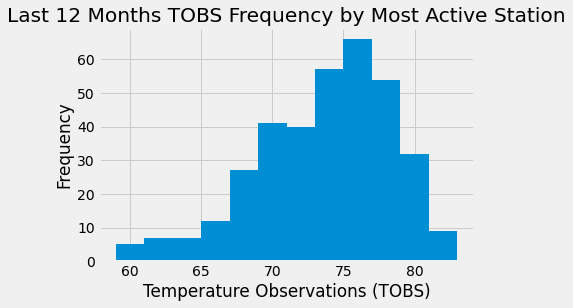

In [192]:
## Plot
plt.hist(active_temps_ls, bins = 12, label = 'tobs')

## Add title and axis names
plt.title('Last 12 Months TOBS Frequency by Most Active Station')
plt.xlabel('Temperature Observations (TOBS)')
plt.ylabel('Frequency')

plt.show()

# Close session

In [193]:
# Close Session
session.close()